#  股價預測

## 欲預測內容
### 預測 [標普500指數(^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/)、 股票之一天內之漲跌。


## 安裝欲使用套件

In [2]:
!pip install xgboost
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [10]:
import warnings
warnings.filterwarnings("ignore")

## 輸入資料
* 輸入資料：各股票的開盤價、收盤價、高點、低點、交易量及
 [VIX (VIX)](https://finance.yahoo.com/quote/%5EVIX/)的收盤價做為初步輸入資料
* 欲預測時間：20年

In [84]:
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator


date = datetime.date.today()
today = str(date)
start_years = str(date.today() + relativedelta(years=-20))
stock_list = ['^GSPC', '^VIX']

# 抓取20年資料
gspc = yf.download(stock_list[0], start = start_years, end = today).reset_index().drop(columns='Adj Close')
vix = yf.download(stock_list[1], start = start_years, end = today).reset_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [85]:
gspc

,Date,Open,High,Low,Close,Volume
0,2002-11-18 00:00:00-05:00,909.830017,915.909973,899.479980,900.359985,1282600000
1,2002-11-19 00:00:00-05:00,900.359985,905.450012,893.090027,896.739990,1337400000
2,2002-11-20 00:00:00-05:00,896.739990,915.010010,894.929993,914.150024,1517300000
3,2002-11-21 00:00:00-05:00,914.150024,935.130005,914.150024,933.760010,2415100000
4,2002-11-22 00:00:00-05:00,933.760010,937.280029,928.409973,930.549988,1626800000
...,...,...,...,...,...,...
5029,2022-11-09 00:00:00-05:00,3810.939941,3818.199951,3744.219971,3748.570068,4645010000
5030,2022-11-10 00:00:00-05:00,3859.889893,3958.330078,3859.889893,3956.370117,5781260000
5031,2022-11-11 00:00:00-05:00,3963.719971,4001.479980,3944.820068,3992.929932,5593310000
5032,2022-11-14 00:00:00-05:00,3977.969971,4008.969971,3956.399902,3957.250000,4561930000


# 特徵工程 ( Clustering )
* 將當日開盤價、收盤價、高點、低點與前一日的開盤價、收盤價、高點、低點分別去進行比較，並且以0,1,2去做區分
* 並將隔天收盤價減去當天收盤價再除以當天收盤價去判對是否 < -0.0026 則為 0 ( 跌 ) 若大於 0.0026 則為2 ( 漲 ) 其餘則為 1 ( 平 )

In [86]:
import collections

rate = 0.0026
gspc['Vix'] = [ 0 if i < -rate  else 2 if i > rate else 1 for i in vix['Close'] - vix['Close'].shift()] # 將 vix 的收盤價一起加入feature
gspc['Label'] = [ 0 if i < -rate else 2 if i > rate else 1 for i in (gspc['Close'].shift(-1) - gspc['Close']) / gspc['Close']]
gspc['Open'] = [ 0 if i < -rate else 2 if i > rate else 1 for i in gspc['Open'] - gspc['Open'].shift()]
gspc['Close'] = [ 0 if i < -rate else 2 if i > rate else 1 for i in gspc['Close'] - gspc['Close'].shift()]
gspc['High'] = [ 0 if i < -rate else 2 if i > rate else 1 for i in gspc['High'] - gspc['High'].shift()]
gspc['Low'] = [ 0 if i < -rate else 2 if i > rate else 1 for i in gspc['Low'] - gspc['Low'].shift()]
gspc['Volume'] = [0 if i < -rate else 2 if i > rate else 1 for i in gspc['Volume'] - gspc['Volume'].shift()]
gspc = gspc.drop(columns='Date') # 將日期去除掉，因為無法將其丟入模型做訓練
gspc = gspc[1:] # 將第一筆資料去除

print(collections.Counter(list(gspc['Label']))) # 確認 Y label 個數量是否平均

gspc

Counter({2: 1937, 0: 1581, 1: 1515})


,Open,High,Low,Close,Volume,Vix,Label
1,0,0,0,0,2,0,2
2,0,2,2,2,2,0,2
3,2,2,2,2,2,0,0
4,2,2,2,0,0,0,1
5,0,0,0,2,0,2,0
...,...,...,...,...,...,...,...
5029,0,0,0,0,2,2,2
5030,2,2,2,2,2,0,2
5031,2,2,2,2,0,0,0
5032,2,2,2,0,0,2,2


## 切割資料 : 
將資料分為訓練資料集 ( 80% ) 及測試資料集 ( 20 % )

In [87]:
from sklearn.model_selection import train_test_split

train, test = gspc.iloc[:,:-1],gspc.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(train, test,  test_size=0.2, shuffle=False)

## 套入模型
* Xgboost

使用 confusion matrix 來了解預測結果及實際結果

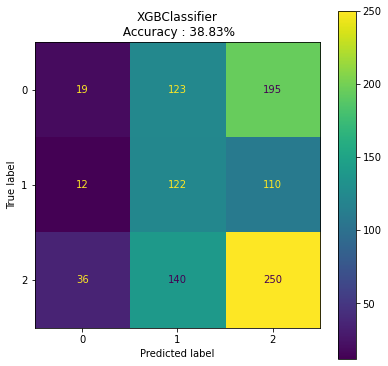

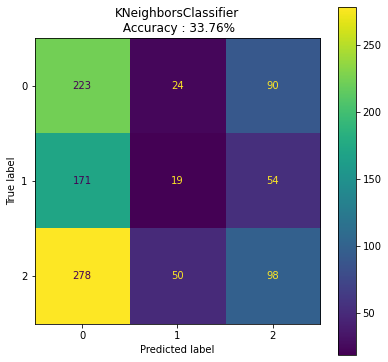

In [109]:
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

plt.rcParams['figure.figsize']=(6.4,6.4)

xgb = xgb.XGBClassifier(objective= 'multi:softprob', booster='gbtree')
KN = KNeighborsClassifier(n_neighbors=3)

def train_model (model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    Accuracy = metrics.accuracy_score(y_test, pred)
    confusion_matrix = metrics.confusion_matrix(y_test, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2])
    cm_display.plot()
    cm_display.ax_.set_title(str(model).split('(')[0] + f'\n Accuracy : {round(Accuracy*100,2)}%')

for model in [xgb,  KN]:
    train_model(model, X_train, y_train, X_test, y_test)

# 特徵工程 ( Clustering )

In [126]:
gspc = yf.download(stock_list[0], start = start_years, end = today).reset_index().drop(columns='Adj Close')

for days in [5, 10, 30, 60, 180]:
    gspc[f'MA_{days}'] = gspc['Close'].rolling(days).mean() # 取該天數 MA
    gspc[f'MA_{days}'] = [1 if i > 0 else 0 for i in  gspc['Open'] - gspc[f'MA_{days}']] # 判斷當天收盤價是否比MA高

gspc['Vix'] = [ 0 if i < -rate  else 2 if i > rate else 1 for i in vix['Close'] - vix['Close'].shift()] # 將 vix 的收盤價一起加入feature
gspc['Label'] = [ 0 if i < -rate else 2 if i > rate else 1 for i in (gspc['Close'].shift(-1) - gspc['Close']) / gspc['Close']]
gspc['Open'] = [ 0 if i < -rate else 2 if i > rate else 1 for i in gspc['Open'] - gspc['Open'].shift()]
gspc['Close'] = [ 0 if i < -rate else 2 if i > rate else 1 for i in gspc['Close'] - gspc['Close'].shift()]
gspc['High'] = [ 0 if i < -rate else 2 if i > rate else 1 for i in gspc['High'] - gspc['High'].shift()]
gspc['Low'] = [ 0 if i < -rate else 2 if i > rate else 1 for i in gspc['Low'] - gspc['Low'].shift()]
gspc['Volume'] = [0 if i < -rate else 2 if i > rate else 1 for i in gspc['Volume'] - gspc['Volume'].shift()]
gspc = gspc.drop(columns='Date') # 將日期去除掉，因為無法將其丟入模型做訓練
gspc = gspc[180:]
gspc

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,MA_5,MA_10,MA_30,MA_60,MA_180,Vix,Label
180,2,0,2,2,0,0,0,0,0,1,0,2
181,2,2,2,2,0,1,0,0,0,1,0,2
182,2,2,2,2,0,1,0,0,0,1,2,2
183,2,2,2,2,2,1,1,0,0,1,0,0
184,2,2,2,0,2,1,1,1,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
5029,0,0,0,0,2,1,1,1,0,0,2,2
5030,2,2,2,2,2,1,1,1,1,0,0,2
5031,2,2,2,2,0,1,1,1,1,0,0,0
5032,2,2,2,0,0,1,1,1,1,0,2,2


## 切割資料 : 
將資料分為訓練資料集 ( 80% ) 及測試資料集 ( 20 % )

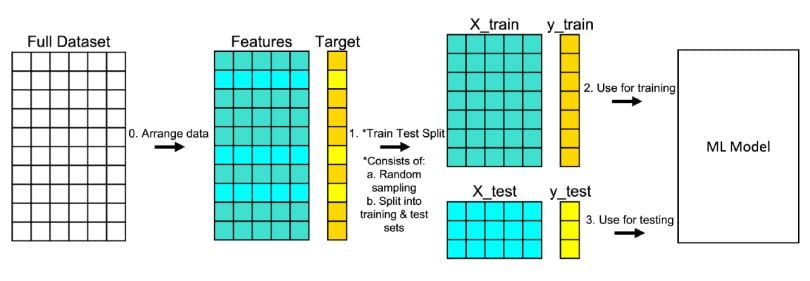

In [127]:
from sklearn.model_selection import train_test_split

train, test = gspc.iloc[:,:-1],gspc.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(train, test,  test_size=0.2, shuffle=False)

## 套入模型
* Xgboost

使用 confusion matrix 來了解預測結果及實際結果

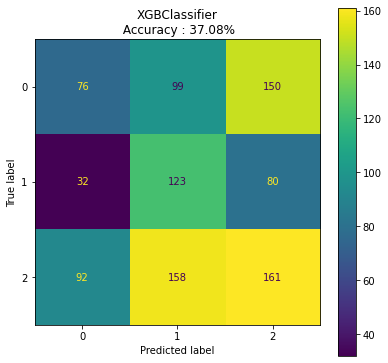

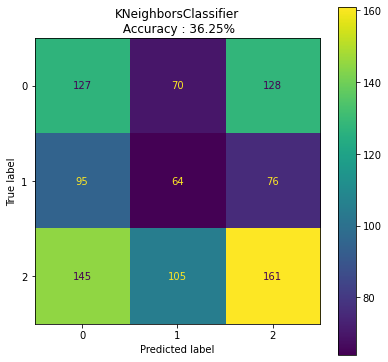

In [128]:
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

plt.rcParams['figure.figsize']=(6.4,6.4)

xgb = xgb.XGBClassifier(objective= 'multi:softprob', booster='gbtree')
KN = KNeighborsClassifier(n_neighbors=3)

def train_model (model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    Accuracy = metrics.accuracy_score(y_test, pred)
    confusion_matrix = metrics.confusion_matrix(y_test, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2])
    cm_display.plot()
    cm_display.ax_.set_title(str(model).split('(')[0] + f'\n Accuracy : {round(Accuracy*100,2)}%')

for model in [xgb,  KN]:
    train_model(model, X_train, y_train, X_test, y_test)

# 特徵工程 ( Linear Regression )
* 將當日開盤價、收盤價、高點、低點與前一日的開盤價、收盤價、高點、低點分別去進行比較，並且以百分比去了解變化量去做區分，並將隔天收盤價當入 Y Label

In [129]:
gspc = yf.download(stock_list[0], start = start_years, end = today).reset_index().drop(columns='Adj Close')

gspc['Vix'] = [i for i in (vix['Close'] - vix['Close'].shift()) / vix['Close'].shift() ]
gspc['Label'] = gspc['Close'].shift(-1)
gspc['Open'] = [i for i in (gspc['Open'] - gspc['Open'].shift()) / gspc['Open'].shift() ]
gspc['High'] = [i for i in (gspc['High'] - gspc['High'].shift()) / gspc['High'].shift() ]
gspc['Low'] = [i for i in (gspc['Low'] - gspc['Low'].shift()) / gspc['Low'].shift() ]
gspc['Close'] = [i for i in (gspc['Close'] - gspc['Close'].shift()) / gspc['Close'].shift() ]
gspc['Volume'] = [i for i in (gspc['Volume'] - gspc['Volume'].shift()) / gspc['Volume'].shift() ]
gspc = gspc.dropna() # 將遺失值去掉
gspc = gspc.drop(columns='Date') # 將日期去除掉，因為無法丟入模型做訓練
gspc

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Vix,Label
1,-0.010409,-0.011420,-0.007104,-0.004021,0.042726,-0.009038,914.150024
2,-0.004021,0.010558,0.002060,0.019415,0.134515,-0.076250,933.760010
3,0.019415,0.021989,0.021477,0.021452,0.591709,-0.059637,930.549988
4,0.021452,0.002299,0.015599,-0.003438,-0.326405,-0.027299,932.869995
5,-0.003438,-0.000139,-0.005493,0.002493,-0.032456,0.039292,913.309998
...,...,...,...,...,...,...,...
5028,0.009604,0.011917,0.005732,0.005598,0.061272,0.048871,3748.570068
5029,-0.001593,-0.010675,-0.011109,-0.020778,0.008110,0.021535,3956.370117
5030,0.012845,0.036701,0.030893,0.055434,0.244617,-0.098122,3992.929932
5031,0.026900,0.010901,0.022003,0.009241,-0.032510,-0.042924,3957.250000


## 切割資料 : 
將資料分為訓練資料集 ( 80% ) 及測試資料集 ( 20 % )


In [130]:
from sklearn.model_selection import train_test_split

train, test = gspc.iloc[:,:-1],gspc.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(train, test,  test_size=0.2, shuffle=False)

## 標準化 :
* 最大最小標準化 將資料之間特徵縮小，並提升模型表現

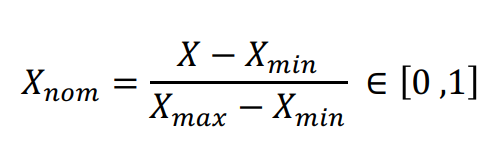

In [131]:
from sklearn.preprocessing import MinMaxScaler


sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 套入模型
* Xgboost

計算 RMSE 及 R^2來確認準確度

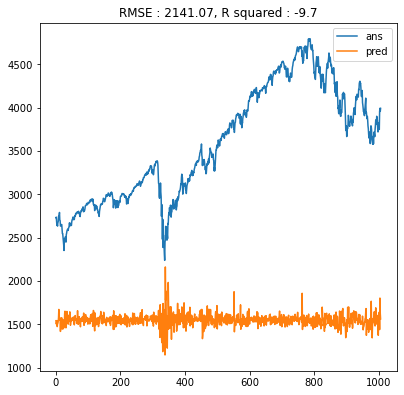

In [135]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



xgb = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror')
xgb.fit(X_train, y_train)

pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(pred, y_test))
r2 = r2_score(y_test, pred)

plt.plot(y_test.reset_index().drop(columns='index'), label='ans')
plt.plot(pred, label='pred')
plt.title(f'RMSE : {round(rmse,2)}, R squared : {round(r2,2)}')
plt.legend()


# 特徵工程 ( Linear Regression )
* 將當日開盤價、收盤價、高點、低點與前一日的開盤價、收盤價、高點、低點分別去進行比較，並且以百分比去了解變化量去做區分，並將隔天收盤價當入 Y Label

In [137]:
gspc = yf.download(stock_list[0], start = start_years, end = today).reset_index().drop(columns='Adj Close')

gspc['Vix'] = vix['Close']
gspc['Label'] = gspc['Close'].shift(-1)
gspc = gspc.dropna()
gspc = gspc.drop(columns = 'Date')
gspc

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Vix,Label
0,909.830017,915.909973,899.479980,900.359985,1282600000,27.660000,896.739990
1,900.359985,905.450012,893.090027,896.739990,1337400000,27.410000,914.150024
2,896.739990,915.010010,894.929993,914.150024,1517300000,25.320000,933.760010
3,914.150024,935.130005,914.150024,933.760010,2415100000,23.809999,930.549988
4,933.760010,937.280029,928.409973,930.549988,1626800000,23.160000,932.869995
...,...,...,...,...,...,...,...
5028,3817.020020,3859.399902,3786.280029,3828.110107,4607640000,25.540001,3748.570068
5029,3810.939941,3818.199951,3744.219971,3748.570068,4645010000,26.090000,3956.370117
5030,3859.889893,3958.330078,3859.889893,3956.370117,5781260000,23.530001,3992.929932
5031,3963.719971,4001.479980,3944.820068,3992.929932,5593310000,22.520000,3957.250000


## 切割資料 : 
將資料分為訓練資料集 ( 80% ) 及測試資料集 ( 20 % )

In [138]:
from sklearn.model_selection import train_test_split

train, test = gspc.iloc[:,:-1],gspc.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(train, test,  test_size=0.2, shuffle=False)

## 標準化 :
* 最大最小標準化 將資料之間特徵縮小，並提升模型表現

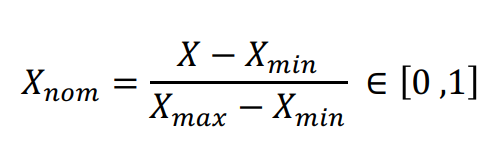

In [139]:
from sklearn.preprocessing import MinMaxScaler


sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 套入模型
* Xgboost

計算 RMSE 及 R^2來確認準確度

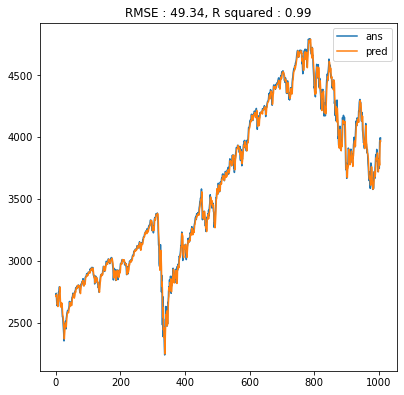

In [141]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



xgb = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror')
xgb.fit(X_train, y_train)

pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(pred, y_test))
r2 = r2_score(y_test, pred)

plt.plot(y_test.reset_index().drop(columns='index'), label='ans')
plt.plot(pred, label='pred')
plt.title(f'RMSE : {round(rmse,2)}, R squared : {round(r2,2)}')
plt.legend()


# 特徵工程 ( Binary Classification )
* 將當日開盤價、收盤價、高點、低點與前一日的開盤價 1 (True)，0 (False) 去做區分是否有比前一天高

In [24]:
gspc['Vix'] = [ 1 if i > 0 else 0 for i in vix['Close'] - vix['Close'].shift()] # 將 vix 的收盤價一起加入feature
gspc['Label'] = [ 1 if i > 0 else 0 for i in gspc['Close'].shift(-1) - gspc['Close']]
gspc['Open'] = [ 1 if i > 0 else 0 for i in gspc['Open'] - gspc['Open'].shift()]
gspc['Close'] = [ 1 if i > 0 else 0 for i in gspc['Close'] - gspc['Close'].shift()]
gspc['High'] = [ 1 if i > 0 else 0 for i in gspc['High'] - gspc['High'].shift()]
gspc['Low'] = [ 1 if i > 0 else 0 for i in gspc['Low'] - gspc['Low'].shift()]
gspc['Volume'] = [ 1 if i > 0 else 0 for i in gspc['Volume'] - gspc['Volume'].shift()]
gspc = gspc.drop(columns='Date') # 將日期去除掉，因為無法將其丟入模型做訓練
gspc = gspc[1:] # 將第一筆資料去除
gspc

,Open,High,Low,Close,Volume,Vix,Label
1,0,0,0,0,1,0,1
2,0,1,1,1,1,0,1
3,1,1,1,1,1,0,0
4,1,1,1,0,0,0,1
5,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...
5029,0,0,0,0,1,1,1
5030,1,1,1,1,1,0,1
5031,1,1,1,1,0,0,0
5032,1,1,1,0,0,1,1


## 切割資料 : 
將資料分為訓練資料集 ( 80% ) 及測試資料集 ( 20 % )

In [25]:
from sklearn.model_selection import train_test_split

train, test = gspc.iloc[:,:-1],gspc.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(train, test,  test_size=0.2, shuffle=False)

## 套入模型
* Xgboost
* RandomForest
* Logistic Regression


使用 confusion matrix 來了解預測結果及實際結果

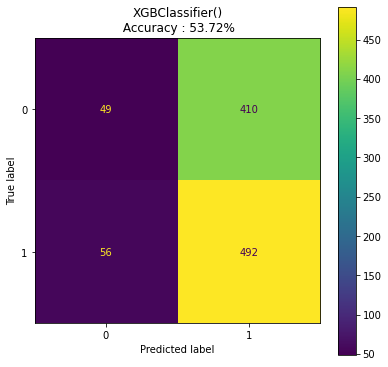

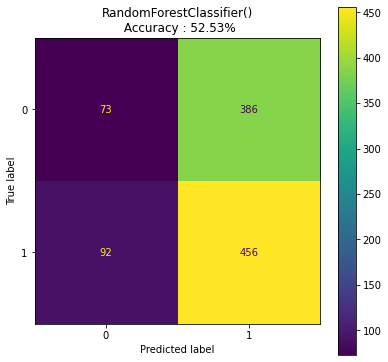

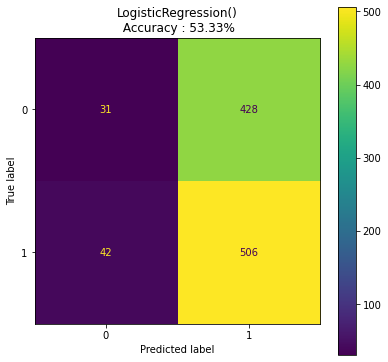

In [30]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

plt.rcParams['figure.figsize']=(6.4,6.4)

xgb = xgb.XGBClassifier()
RF = RandomForestClassifier()
LR = LogisticRegression()

def train_model (model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    Accuracy = metrics.accuracy_score(y_test, pred)
    confusion_matrix = metrics.confusion_matrix(y_test, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1])
    cm_display.plot()
    cm_display.ax_.set_title(str(model).split('(')[0] + f'\n Accuracy : {round(Accuracy*100,2)}%')

for model in [xgb, RF, LR]:
    train_model(model, X_train, y_train, X_test, y_test)